# BEE 4750 Homework 5: Solid Waste Disposal

**Name**: Anthony Nicolaides

**ID**: ajn68

> **Due Date**
>
> Friday, 11/10/23, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   In Problem 2, you will add a CO<sub>2</sub> constraint to the
    capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Documents/Julia/BEE4750/hw/hw05-anthonynic28`


In [2]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

## Background

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided in the table below.

|    **Disposal Facility**     | **Capacity** (Mg/d) | **Fixed cost** (\$/d) | **Tipping Fee**  (\$/Mg) | **Recycling Cost** (\$/Mg) |
|:----------------------------:|:-------------------:|:---------------------:|:------------------------:|:--------------------------:|
|           Landfill           |         200         |         2000          |            50            |              -             |
| Materials Recycling Facility |         350         |         1500          |            7             |    40 (per Mg recycled)    |
|   Waste-to-Energy Facility   |         210         |         2500          |            60            |              -             |

Transportation costs are \$1.5/Mg-km, and the relative distances between
the cities and facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

|   **Component**   | **% of total mass** | **Combustion ash** (%) | **MRF Recycling rate** (%) |
|:-----------------:|:-------------------:|:----------------------:|:--------------------------:|
|    Food Wastes    |         15          |           8            |             0              |
| Paper & Cardboard |         40          |           7            |             55             |
|     Plastics      |          5          |           5            |             15             |
|     Textiles      |          3          |           10           |             10             |
|  Rubber, Leather  |          2          |           15           |             0              |
|       Wood        |          5          |           2            |             30             |
|    Yard Wastes    |         18          |           2            |             40             |
|       Glass       |          4          |          100           |             60             |
|      Ferrous      |          2          |          100           |             75             |
|     Aluminum      |          2          |          100           |             80             |
|    Other Metal    |          1          |          100           |             50             |
|   Miscellaneous   |          3          |           70           |             0              |

The information in the above table will help you determine the overall
recycling and ash fractions. Note that the recycling residuals, which
may be sent to either landfill or the WTE, have different ash content
than the ash content of the original MSW. You will need to determine
these fractions to construct your mass balance constraints.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

## Problems (Total: 40 Points)

### Problem 1 (22 points)

In this problem, you will develop an optimal disposal plan for the two
cities.

#### Problem 1.1 (3 points)

Based on the information above, calculate the overall recycling and ash
fractions for the waste produced by each city.

In [3]:
# put all data from tables into dictionaries for easy access

WTE_dict = Dict{String,Int}(
    "capacity" => 210, # Mg / d
    "fixed" => 2500, # USD / d
    "tipping" => 60, # USD / Mg
    "WTE" => 0, # km
    "MRF" => 15, # km
    "LF" => 18, # km
)

MRF_dict = Dict{String,Int}(
    "capacity" => 350, # Mg / d
    "fixed" => 1500, # USD / d
    "tipping" => 7, # USD / Mg
    "recycling" => 40, # USD / recycled Mg
    "WTE" => 15, # km
    "MRF" => 0, # km
    "LF" => 32, # km
)

LF_dict = Dict{String,Int}(
    "capacity" => 200, # Mg / d
    "fixed" => 2000, # USD / d
    "tipping" => 50, # USD / Mg
    "WTE" => 18, # km
    "MRF" => 32, # km
    "LF" => 0, # km
)

city1_dict = Dict{String,Int}(
    "production" => 100, # Mg / day
    "WTE" => 15, # km
    "MRF" => 30, # km
    "LF" => 5 # km
)

city2_dict = Dict{String,Int}(
    "production" => 90, # Mg / day
    "WTE" => 10, # km
    "MRF" => 25, # km
    "LF" => 15 # km
)

city3_dict = Dict{String,Int}(
    "production" => 120, # Mg / day
    "WTE" => 20, # km
    "MRF" => 45, # km
    "LF" => 13 # km
)

transportationCost = 1.5 # USD / Mg-km

totalMass_dict = Dict{String,Float64}( # percent of total
    "food wastes" => 0.15,
    "papers & cardboard" => 0.40,
    "plastics" => 0.05,
    "textiles" => 0.03,
    "rubber & leather" => 0.02,
    "wood" => 0.05,
    "yard wastes" => 0.18,
    "glass" => 0.04,
    "ferrous" => 0.02,
    "aluminum" => 0.02,
    "other metals" => 0.01,
    "miscellaneous" => 0.03,
)
totalMass_dict = sort(totalMass_dict)

combustionAsh_dict = Dict{String,Float64}( # percent of total
    "food wastes" => 0.08,
    "papers & cardboard" => 0.07,
    "plastics" => 0.05,
    "textiles" => 0.10,
    "rubber & leather" => 0.15,
    "wood" => 0.02,
    "yard wastes" => 0.02,
    "glass" => 1.0,
    "ferrous" => 1.0,
    "aluminum" => 1.0,
    "other metals" => 1.0,
    "miscellaneous" => 0.70,
)
combustionAsh_dict = sort(combustionAsh_dict)

MRFrecyclingRate_dict = Dict{String,Float64}( # percent of total
    "food wastes" => 0.0,
    "papers & cardboard" => 0.55,
    "plastics" => 0.15,
    "textiles" => 0.10,
    "rubber & leather" => 0,
    "wood" => 0.30,
    "yard wastes" => 0.40,
    "glass" => 0.60,
    "ferrous" => 0.75,
    "aluminum" => 0.80,
    "other metals" => 0.50,
    "miscellaneous" => 0.0,
)
MRFrecyclingRate_dict = sort(MRFrecyclingRate_dict);

In [4]:
# calculate fractions
MRF_recycling_rate = round(sum(collect(values(MRFrecyclingRate_dict)) .*
                               collect(values(totalMass_dict))), digits=7)
WTE_residual_ash = round(sum(collect(values(combustionAsh_dict)) .*
                          collect(values(totalMass_dict))), digits=7)
println("Fraction of MRF waste recycled: ", MRF_recycling_rate)
println("Fraction of WTE waste turning to residual ash: ", WTE_residual_ash)

Fraction of MRF waste recycled: 0.3775
Fraction of WTE waste turning to residual ash: 0.1641


#### Problem 1.2 (2 points)

What are the decision variables for your optimization problem? Provide
notation and variable meaning.

| **Decision Variable** | **Meaning** | **Unit** |
|:------------:|:-----------:|:--------:|
|   W<sub>i,j</sub>      | Waste transported from city i to disposal j | Mg/day |
|   R<sub>k,j</sub>      | Residual waste transported from disposal k to disposal j | Mg/day |
|   Y<sub>j</sub>        | Operational status (on/off) of disposal | binary |


#### Problem 1.3 (3 points)

Formulate the objective function. Make sure to include any needed
derivations or justifications for your equation(s).

| **Variable** | **Meaning** | **Unit** |
|:------------:|:-----------:|:--------:|
|   $a$<sub>i,j</sub>      | Cost of transporting waste from source i to disposal j | \$/Mg-km |
|   $b$<sub>j</sub>        | Variable cost of disposing waste at disposal j | \$/Mg |
|   $c$<sub>j</sub>        | Fixed costs of operating disposal j | \$/day |
|   $d$<sub>j</sub>        | Recycling cost at disposal j | \$/Mg |
|   $e$<sub>j</sub>        | Fraction of waste recycled at disposal j  | unitless |
|   $f$        | Fraction of waste turned to residual ash at WTE  | unitless |
|   $g$<sub>k,j</sub>      | Cost of transporting waste from disposal k to disposal j | \$/Mg-km |
|   $h$<sub>k,j</sub>      | Distance between disposal k and disposal j | km |
|   $I$        | Cities/waste sources being considered  | unitless |
|   $i$        | A specific city/waste source  | unitless |
|   $J$        | Disposals being considered  | unitless |
|   $j$        | A specific disposal  | unitless |
|   $K$        | Disposals being considered  | unitless |
|   $k$        | A specific disposal | unitless |
|   $l$<sub>i,j</sub>      | Distance between source i and disposal j | km |
|   $S$<sub>i</sub>        | Waste production at source i | Mg/day |
|   $N$<sub>j</sub>        | Capacity limit at disposal j | Mg/d |

Calculate cost of recycled waste from city i and disposal k to disposal j:

Specifically for MRF (j=2), but is generalized to easily fit into objective function.

Multiplying the waste by the fraction e_j gives the amount of waste that will be recycled. The cost of this is found by multipling the recycled waste by d<sub>j</sub>.

\begin{equation}
\begin{aligned}
\sum_{i \in \mathcal{I}, j \in \mathcal{J}}(d_j * e_j * W_i,_j)
\end{aligned}
\end{equation}

Calculate the transportation cost from city i and disposal k to disposal j:

First, multiply the distance from city i to disposal j (i.e. l<sub>i,j</sub>) by the cost of transportation a<sub>i,j</sub>. Then this value is multiplied by the amount of waste that is being transported, W<sub>i,j</sub>.

Second, multiply the distance from disposal k to disposal j (i.e. h<sub>k,j</sub>) by the cost of transportation g<sub>k,j</sub>. Then this value is multiplied by the amount of waste that is being transported, R<sub>k,j</sub>.

Third, add the two values together.

\begin{equation}
\begin{aligned}
\sum_{i \in \mathcal{I}, j \in \mathcal{J}}(a_i,_j * l_i,_j * W_i,_j) +\\
\sum_{k \in \mathcal{K}, j \in \mathcal{J}}(g_k,_j * h_k,_j * R_k,_j)
\end{aligned}
\end{equation}

Calculate the cost to fixed operating disposal j and variable cost to send waste from city i and disposal k to disposal j:

Find the amount of waste that is being transported to disposal j from cities and disposals, then mutiply the total waste by the cost to handle that much waste at disposal j.

Add the cost to simply operate the disposal to this value.

\begin{equation}
\begin{aligned}
\sum_{j \in \mathcal{J}}[c_j + b_j[\sum_{i \in \mathcal{I}} (W_i,_j) + \sum_{k \in \mathcal{K}} (R_k,_j)]] \\
\end{aligned}
\end{equation}

Note - Need variable Y (binary) to indicate whether or not to operate disposal j:

If no waste is being transported to disposal j, then disposal j does not need to be operating. Therefore, c<sub>j</sub> can be multiplied by 0 to effectively shut down disposal j.

\begin{equation}
\begin{aligned}
\sum_{j \in \mathcal{J}}[(c_j * Y_j) + b_j[\sum_{i \in \mathcal{I}} (W_i,_j) + \sum_{k \in \mathcal{K}} (R_k,_j)]] \\
\end{aligned}
\end{equation}

Add all costs together and minimize total cost:

\begin{equation}
\begin{aligned}
& \min_{W_i,_j, R_k,_j, Y_j}  \sum_{j \in \mathcal{J}}[\sum_{i \in \mathcal{I}} ([(d_j*e_j)+ b_j+(a_i,_j * l_i,_j)] *W_i,_j) + \\
& \sum_{k \in \mathcal{K}} ([b_j +(g_k,_j * h_k,_j)]  * R_k,_j) + (c_j * Y_j)]
\end{aligned}
\end{equation}

#### Problem 1.4 (4 points)

Derive all relevant constraints. Make sure to include any needed
justifications or derivations.

All waste transported from city i must equal the waste production of city i (mass balance):

\begin{equation}
\begin{aligned}
\sum_{j \in \mathcal{J}} (W_i,_j) = S_i
\end{aligned}
\end{equation}

All waste transported from disposal j must equal the correct fraction of waste that was transported to disposal j (mass balance):

Specifically, WTE only needs to send (f) percent of the waste transported to WTE, and MRF only needs to send (1-e_2) percent of the waste transported to MRF:

Keeping in mind that WTE (j=1) can obtain waste from all cities and MRF, add up the waste sent from these sources and multiply the sum by the correct fraction (f).

Keeping in mind that MRF (j=2) can obtain waste from all cities, add up the waste sent from these sources and multiply the sum by the correct fraction (1-e<sub>2</sub>).

\begin{equation}
\begin{aligned}
& f*(\sum_{i \in \mathcal{I}} (W_i,_1) + R_2,_1) = R_1,_3 \\
& (1-e_2 )* \sum_{i \in \mathcal{I}} (W_i,_2) = R_2,_1 + R_2,_3
\end{aligned}
\end{equation}

The amount of waste transported to disposal j must be less then or equal to the max capacity of disposal j:

WTE (j=1) can obtain waste from all cities and MRF, so add up waste sent from these sources and make sure they are less than or equal to the max capacity.

MRF (j=2) can obtain waste from all cities , so add up waste sent from these sources and make sure they are less than or equal to the max capacity.

LF (j=3) can obtain waste from all cities, WTE, and MRF, so add up waste sent from these sources and make sure they are less than or equal to the max capacity.

\begin{equation}
\begin{aligned}
& \sum_{i \in \mathcal{I}} (W_i,_1) + R_2,_1 \leq N_1 \\
& \sum_{i \in \mathcal{I}} (W_i,_2) \leq N_2 \\
& \sum_{i \in \mathcal{I}} (W_i,_3) + R_1,_3 + R_2,_3 \leq N_3
\end{aligned}
\end{equation}


To know when to operate disposal j, the variable Y needs to be defined as 1 when there is waste being transported to disposal j and 0 when no waste is being transported to dispsoal j: 

See previous contraint (above) for how sources of waste were obtained for each disposal. 
If the sum of waste sent to disposal j is a non-zero value, then the disposal needs to be operating, so Y is 1, if the sum if zero then set Y to 0 to turn off the disposal.

\begin{equation}
\begin{aligned}
& Y_1 = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_1) + R_2,_1 = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_1) + R_2,_1 > 0 \end{cases} \\
& Y_2 = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_2) = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_2) > 0 \end{cases} \\
& Y_3 = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_3) + R_1,_3 + R_2,_3 = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_3) + R_1,_3 + R_2,_3 > 0 \end{cases}
\end{aligned}
\end{equation}

To use JuMP and the HiGHS Optimizer, Big-M notation is used for the Y constraints:

\begin{equation}
\begin{aligned}
& \sum_{i \in \mathcal{I}} (W_i,_1) + R_2,_1 \leq M * Y_1 \\
& \sum_{i \in \mathcal{I}} (W_i,_2) \leq M * Y_2 \\
& \sum_{i \in \mathcal{I}} (W_i,_3) + R_1,_3 + R_2,_3 \leq M * Y_3
\end{aligned}
\end{equation}

The amount of waste transported from city i and disposal k to disposal j must not be negative:

\begin{equation}
\begin{aligned}
W_i,_j \geq 0 \\
R_k,_j \geq 0
\end{aligned}
\end{equation}

The complete objective function with constraints:

\begin{equation}
\begin{aligned}
& \min_{W_i,_j, R_k,_j, Y_j}  \sum_{j \in \mathcal{J}}[\sum_{i \in \mathcal{I}} ([(d_j*e_j)+ b_j+(a_i,_j * l_i,_j)] *W_i,_j) + \\
& \sum_{k \in \mathcal{K}} ([b_j +(g_k,_j * h_k,_j)]  * R_k,_j) + (c_j * Y_j)] \\
\text{subject to} & \\
& \sum_{j \in \mathcal{J}} (W_i,_j) = S_i \\
& f*(\sum_{i \in \mathcal{I}} (W_1,_j) + R_2,_1) = R_1,_3 \\
& (1-e_2 )* \sum_{i \in \mathcal{I}} (W_2,_j) = R_2,_1 + R_2,_3 \\
& \sum_{i \in \mathcal{I}} (W_i,_1) + R_2,_1 \leq N_1 \\
& \sum_{i \in \mathcal{I}} (W_i,_2) \leq N_2 \\
& \sum_{i \in \mathcal{I}} (W_i,_3) + R_1,_3 + R_2,_3 \leq N_3 \\
& Y_1 = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_1) + R_2,_1 = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_1) + R_2,_1 > 0 \end{cases} \\
& Y_2 = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_2) = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_2) > 0 \end{cases} \\
& Y_3 = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_3) + R_1,_3 + R_2,_3 = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_3) + R_1,_3 + R_2,_3 > 0 \end{cases} \\
& W_i,_j \geq 0 \\
& R_k,_j \geq 0
\end{aligned}
\end{equation}

#### Problem 1.5 (3 points)

Implement your optimization problem in `JuMP`.

In [5]:
# build model

# define sets
I = 1:3 # three sources
J = 1:3 # three disposals
K = J # disposal can send to the other disposals

# define indices
city1 = 1
city2 = 2
city3 = 3
WTE = 1
MRF = 2
LF = 3

waste_model = Model(HiGHS.Optimizer)

# variable notation for non-decision variables
M = 1.9e14 # Big-M notation

a = zeros(3, 3) .+ transportationCost # USD / Mg-km
b = [WTE_dict["tipping"] MRF_dict["tipping"] LF_dict["tipping"]] # USD/Mg
c = [WTE_dict["fixed"] MRF_dict["fixed"] LF_dict["fixed"]] # USD/day
d = [0 MRF_dict["recycling"] 0] # USD/Mg recycled
e = [0 MRF_recycling_rate 0] # percentage
f = WTE_residual_ash # percentage
l = [ # km from city i to disposal j
    city1_dict["WTE"] city1_dict["MRF"] city1_dict["LF"]
    city2_dict["WTE"] city2_dict["MRF"] city2_dict["LF"]
    city3_dict["WTE"] city3_dict["MRF"] city3_dict["LF"]
]
g = zeros(3, 3) .+ transportationCost # USD / Mg-km
h = [ # km from disposal k to disposal j
    WTE_dict["WTE"] WTE_dict["MRF"] WTE_dict["LF"]
    MRF_dict["WTE"] MRF_dict["MRF"] MRF_dict["LF"]
    LF_dict["WTE"] LF_dict["MRF"] LF_dict["LF"]
]
N = [WTE_dict["capacity"]
    MRF_dict["capacity"]
    LF_dict["capacity"]] # Mg/day
S = [city1_dict["production"] # Mg/day
    city2_dict["production"]
    city3_dict["production"]]

# decision variables
@variable(waste_model, W[i in I, j in J] >= 0) # Mg/day
@variable(waste_model, R[k in K, j in J] >= 0) # Mg/day
@variable(waste_model, Y[j in J], binary = true) # binary

# constraints
@constraint(waste_model, constraint_waste[i in I],
    sum(W[i, j] for j in J) == S[i]) # waste constraint

@constraint(waste_model, constraint_conservationWTE, # mass balance
    R[WTE, LF] ==
    f * (sum(W[i, WTE] for i in I) + R[MRF, WTE]))

@constraint(waste_model, constraint_conservationMRF, # mass balance
    R[MRF, WTE] + R[MRF, LF] ==
    (1 - e[MRF]) * sum(W[i, MRF] for i in I))

@constraint(waste_model, constraint_capacityWTE1, # capacity constraint
    sum(W[i, WTE] for i in I) + R[MRF, WTE] <= N[WTE])

@constraint(waste_model, constraint_capacityMRF, # capacity constraint
    sum(W[i, MRF] for i in I) <= N[MRF])

@constraint(waste_model, constraint_capacityLF, # capacity constraint
    sum(W[i, LF] for i in I) + R[MRF, LF] + R[WTE, LF] <= N[LF])

@constraint(waste_model, constraint_operatingWTE, # fixed cost constraint
    sum(W[i, WTE] for i in I) + R[MRF, WTE] <= M * Y[WTE])

@constraint(waste_model, constraint_operatingMRF, # fixed cost constraint
    sum(W[i, MRF] for i in I) <= M * Y[MRF])

@constraint(waste_model, constraint_operatingLF, # fixed cost constraint
    sum(W[i, LF] for i in I) + R[MRF, LF] + R[WTE, LF] <= M * Y[LF])

@objective(waste_model, Min,
    sum(
        sum(
            (((d[j] * e[j]) + (a[i, j] * l[i, j]) + b[j]) *
             W[i, j]) for i in I) +
        sum(
            (((g[k, j] * h[k, j]) + b[j]) *
             R[k, j]) for k in K) +
        (c[j] * Y[j]) for j in J)
)


82.5 W[1,1] + 75 W[2,1] + 90 W[3,1] + 60 R[1,1] + 82.5 R[2,1] + 87 R[3,1] + 2500 Y[1] + 67.1 W[1,2] + 59.6 W[2,2] + 89.6 W[3,2] + 29.5 R[1,2] + 7 R[2,2] + 55 R[3,2] + 1500 Y[2] + 57.5 W[1,3] + 72.5 W[2,3] + 69.5 W[3,3] + 77 R[1,3] + 98 R[2,3] + 50 R[3,3] + 2000 Y[3]

#### Problem 1.6 (2 points)

Find the optimal solution. Report the optimal objective value.

In [6]:
set_silent(waste_model) # supress optimize model output
optimize!(waste_model);

obj_value = objective_value(waste_model)
println("The optimal cost is \$", round(obj_value, digits = 2), " per day")

The optimal cost is $27855.48 per day


#### Problem 1.7 (5 points)

Draw a diagram showing the flows of waste between the cities and the
facilities. Which facilities (if any) will not be used? Does this
solution make sense?

In [7]:
# need to see how each city and disposal transport waste

display(value.(W).data) # Mg/day, city i to disposal j

display(value.(R).data) # Mg/day, disposal k to disposal j

display(value.(Y).data) # binary

3×3 Matrix{Float64}:
  0.0      0.0  100.0
 90.0     -0.0   -0.0
 41.5947   0.0   78.4053

3×3 Matrix{Float64}:
 0.0  0.0  21.5947
 0.0  0.0   0.0
 0.0  0.0   0.0

3-element Vector{Float64}:
  1.0
 -0.0
  1.0

In [8]:
# round for nice formatting
W1 = round.(value.(W).data, digits=2)
R1 = round.(value.(R).data, digits=2);

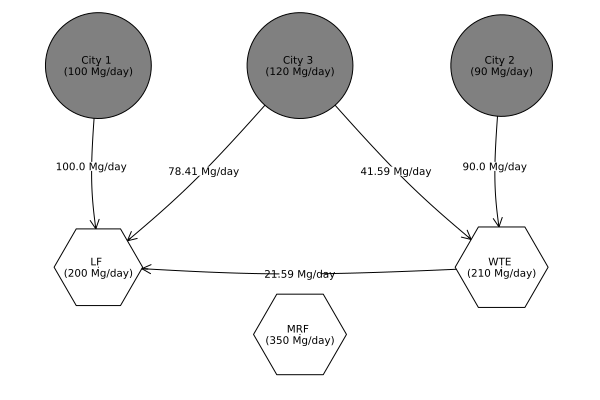

In [9]:
# construct diagram

names = [
    "City 1 \n(" * string(city1_dict["production"], " Mg/day)"),
    "City 2 \n(" * string(city2_dict["production"], " Mg/day)"),
    "City 3 \n(" * string(city3_dict["production"], " Mg/day)"),
    "WTE \n(" * string(WTE_dict["capacity"], " Mg/day)"),
    "MRF \n(" * string(MRF_dict["capacity"], " Mg/day)"),
    "LF \n(" * string(LF_dict["capacity"], " Mg/day)")
]

# formatting
shapes = [:circle, :circle, :circle, :hexagon, :hexagon, :hexagon]
colors = [:gray, :gray, :gray, :white, :white, :white, :white]
sizes = 0.16
xpos = [-0.5, 2.5, 1, 2.5, 1, -0.5]
ypos = [1, 1, 1, -0.5, -1, -0.5]
cities = length(S) # offset for disposals being after cities in matrix

edge_labels = Dict(
    (city1, LF + cities) => string(value.(W1[city1, LF]), " Mg/day"),
    (city2, WTE + cities) => string(value.(W1[city2, WTE]), " Mg/day"),
    (city3, WTE + cities) => string(value.(W1[city3, WTE]), " Mg/day"),
    (city3, LF + cities) => string(value.(W1[city3, LF]), " Mg/day"),
    (WTE + cities, LF + cities) => string(value.(R1[WTE, LF]), " Mg/day")
)

# build matrix based on connections
A = zeros(length(names), length(names))
[A[i[1], i[2]] = 1 for i in collect(keys(edge_labels))]

graphplot(A,
    names=names,
    edgelabel=edge_labels,
    markersizes=sizes,
    markershapes=shapes,
    markercolor=colors,
    x=xpos, y=ypos
)

MRF will not be used at all. This makes sense because the MRF cost more per Mg sent to it compared to the other disposals. MRF needs to recycle the waste, which cost 40 USD/Mg recycled. This means that the more that is recycled, the higher the cost. Unless the recycling cost is much lower than it currently is, then it is cheaper to not use MRF at all, hence why it is not used for the optimal solution.

### Problem 2 (18 points)

It is projected that in the near future the state will introduce a
carbon tax that will increase the cost for transportation and for
disposal by incineration. It is estimated that the additional costs will
be:

-   tipping fee for the WTE facility will increase to\$75/Mg; and
-   transportation costs will increase to \$2/Mg-km.

In this context, the cities are considering adding another landfill and
want to know if this would be cost-effective compared to using the
current facilities with the carbon tax. This landfill would have a
maximum capacity of 100 Mg/day and would be located with the following
distances from the existing sites (excluding LF1):

| **City/Facility** | **Distance to LF2 (km)** |
|:-----------------:|:------------------------:|
|         1         |            45            |
|         2         |            35            |
|         3         |            15            |
|        MRF        |            35            |
|        WTE        |            50            |

The fixed cost of operating this facility would be the same as the first
landfill, but the tipping cost would be increased to \$60/Mg-day.

#### Problem 2.1 (5 points)

What changes are needed to your optimization program from Problem 1 for
this decision problem? Formulate any different variables, objectives,
and/or constraints.

Now that a new landfill is added, an update to the constraints are needed. The objective function does not change as the only change is J=1:3 is now J=1:4 and the value of the transportation cost, but the equation itself is the same.

See first declaration of this constraint for derivation. 

All waste transported from disposal j must equal the correct fraction of waste that was transported to disposal j (mass balance):

Specifically, WTE only needs to send (f) percent of the waste transported to WTE and MRF only needs to send (1-e_2) percent of the waste transported to MRF:

Now need to accommdate the new disposal (j=4), LF is not connected to LF2:

\begin{equation}
\begin{aligned}
& f*(\sum_{i \in \mathcal{I}} (W_1,_j) + R_2,_1) = R_1,_3 + R_1,_4 \\
& (1-e_2)* \sum_{i \in \mathcal{I}} (W_2,_j) = R_2,_1 + R_2,_3 + R_2,_4
\end{aligned}
\end{equation}

See first declaration of this constraint for derivation. 

The amount of waste transported to disposal j must be less then or equal to the max capacity of disposal j:

Now need to accommdate the new disposal (j=4), LF is not connected to LF2:


\begin{equation}
\begin{aligned}
\sum_{i \in \mathcal{I}} (W_i,_4) + R_1,_4 + R_2,_4 \leq N_4
\end{aligned}
\end{equation}

See first declaration of this constraint for derivation. 

A new Y indicator variable needs to be added for the new disposal (j=4), LF is not connected to LF2:

Big-M notation is also defined:

\begin{equation}
\begin{aligned}
& Y_4 = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_4) + R_1,_4 + R_2,_4 = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_4) + R_1,_4 + R_2,_4 > 0 \end{cases} \\
& \sum_{i \in \mathcal{I}} (W_i,_4) + R_1,_4 + R_2,_4 \leq M * Y_4
\end{aligned}
\end{equation}

Objective functionw with updated constraints:

\begin{equation}
\begin{aligned}
& \min_{W_i,_j, R_k,_j, Y_j}  \sum_{j \in \mathcal{J}}[\sum_{i \in \mathcal{I}} ([(d_j*e_j)+ b_j+(a_i,_j * l_i,_j)] *W_i,_j) + \\
& \sum_{k \in \mathcal{K}} ([b_j +(g_k,_j * h_k,_j)]  * R_k,_j) + (c_j * Y_j)] \\
\text{subject to} & \\
& \sum_{j \in \mathcal{J}} (W_i,_j) = S_i \\
& f*(\sum_{i \in \mathcal{I}} (W_1,_j) + R_2,_1) = R_1,_3 + R_1,_4 \\
& (1-e_2)* \sum_{i \in \mathcal{I}} (W_2,_j) = R_2,_1 + R_2,_3 + R_2,_4 \\
& \sum_{i \in \mathcal{I}} (W_i,_1) + R_2,_1 \leq N_1 \\
& \sum_{i \in \mathcal{I}} (W_i,_2) \leq N_2 \\
& \sum_{i \in \mathcal{I}} (W_i,_3) + R_1,_3 + R_2,_3 \leq N_3 \\
& \sum_{i \in \mathcal{I}} (W_i,_4) + R_1,_4 + R_2,_4 \leq N_4 \\
& Y_1 = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_1) + R_2,_1 = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_1) + R_2,_1 > 0 \end{cases} \\
& Y_2 = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_2) = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_2) > 0 \end{cases} \\
& Y_3 = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_3) + R_1,_3 + R_2,_3 = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_3) + R_1,_3 + R_2,_3 > 0 \end{cases} \\
& Y_4 = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_4) + R_1,_4 + R_2,_4 = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_4) + R_1,_4 + R_2,_4 > 0 \end{cases} \\
& W_i,_j \geq 0 \\
& R_k,_j \geq 0
\end{aligned}
\end{equation}

In [10]:
# Updating values & putting new values in into dictionaries for easy access

WTE_dict["tipping"] = 75 # USD/Mg
transportationCost = 2 # USD/Mg-km
city1_dict["LF2"] = 45 # km
city2_dict["LF2"] = 35 # km
city3_dict["LF2"] = 15 # km
WTE_dict["LF2"] = 50 # km
MRF_dict["LF2"] = 35 # km
LF_dict["LF2"] = 1e14 # km, set very high to indicate no connection

LF2_dict = Dict{String, Int64}(
    "capacity" => 100, # Mg/day
    "tipping" => 60, # USD/Mg
    "fixed" => LF_dict["fixed"], # USD/day
    "WTE" => 50, # km
    "MRF" => 35, # km
    "LF" => 1e14, # km, set very high to indicate no connection
    "LF2" => 0, # km
);

In [11]:
# A: First find optimal cost with carbon tax and no new landfill

# update non-decision variables
a = zeros(3, 3) .+ transportationCost # USD / Mg-km
b = [WTE_dict["tipping"] MRF_dict["tipping"] LF_dict["tipping"]] # USD/Mg
g = zeros(3, 3) .+ transportationCost # USD / Mg-km

# update objective function with updated non-decision variables
@objective(waste_model, Min,
    sum(
        sum(
            (((d[j] * e[j]) + (a[i, j] * l[i, j]) + b[j]) *
             W[i, j]) for i in I) +
        sum(
            (((g[k, j] * h[k, j]) + b[j]) *
             R[k, j]) for k in K) +
        (c[j] * Y[j]) for j in J)
)

105 W[1,1] + 95 W[2,1] + 115 W[3,1] + 75 R[1,1] + 105 R[2,1] + 111 R[3,1] + 2500 Y[1] + 82.1 W[1,2] + 72.1 W[2,2] + 112.1 W[3,2] + 37 R[1,2] + 7 R[2,2] + 71 R[3,2] + 1500 Y[2] + 60 W[1,3] + 80 W[2,3] + 76 W[3,3] + 86 R[1,3] + 114 R[2,3] + 50 R[3,3] + 2000 Y[3]

#### Problem 2.2 (3 points)

Implement the new optimization problem in `JuMP`.

In [12]:
# A: First find optimal cost with carbon tax and no new landfill

# find optimal solution without the new landfill
set_silent(waste_model) # supress optimize model output
optimize!(waste_model);

obj_value_noLF2 = objective_value(waste_model)
println("The optimal cost is \$", round(obj_value_noLF2, digits = 2),
 " per day with the carbon tax and no new landfill")

The optimal cost is $31649.34 per day with the carbon tax and no new landfill


In [13]:
# B: Second find optimal cost with carbon tax and new landfill

# rebuild model with updated changes

# define sets
I = 1:3 # three sources
J = 1:4 # four disposals
K = J # disposal can send to the other disposals

# define indices
city1 = 1
city2 = 2
city3 = 3
WTE = 1
MRF = 2
LF = 3
LF2 = 4


waste_model = Model(HiGHS.Optimizer)

# variable notation for non-decision variables
M = 1.9e14 # Big-M notation

a = zeros(3, 4) .+ transportationCost # USD / Mg-km
b = [WTE_dict["tipping"] # USD/Mg
    MRF_dict["tipping"]
    LF_dict["tipping"]
    LF2_dict["tipping"]]

c = [WTE_dict["fixed"] # USD/day
    MRF_dict["fixed"]
    LF_dict["fixed"]
    LF2_dict["fixed"]]

d = [0 MRF_dict["recycling"] 0 0] # USD/Mg recycled
e = [0 MRF_recycling_rate 0 0] # percentage
f = WTE_residual_ash # percentage
g = zeros(4, 4) .+ transportationCost # USD / Mg-km
h = [ # km from disposal k to disposal j
    WTE_dict["WTE"] WTE_dict["MRF"] WTE_dict["LF"] WTE_dict["LF2"]
    MRF_dict["WTE"] MRF_dict["MRF"] MRF_dict["LF"] MRF_dict["LF2"]
    LF_dict["WTE"] LF_dict["MRF"] LF_dict["LF"] LF_dict["LF2"]
    LF2_dict["WTE"] LF2_dict["MRF"] LF2_dict["LF"] LF2_dict["LF2"]
]
l = [ # km from city i to disposal j
    city1_dict["WTE"] city1_dict["MRF"] city1_dict["LF"] city1_dict["LF2"]
    city2_dict["WTE"] city2_dict["MRF"] city2_dict["LF"] city2_dict["LF2"]
    city3_dict["WTE"] city3_dict["MRF"] city3_dict["LF"] city3_dict["LF2"]
]
N = [WTE_dict["capacity"] # Mg/day
    MRF_dict["capacity"]
    LF_dict["capacity"]
    LF2_dict["capacity"]]
    
S = [city1_dict["production"] # Mg/day
    city2_dict["production"]
    city3_dict["production"]]

# decision variables
@variable(waste_model, W[i in I, j in J] >= 0) # Mg/day
@variable(waste_model, R[k in K, j in J] >= 0) # Mg/day
@variable(waste_model, Y[j in J], binary = true) # binary

# constraints
@constraint(waste_model, constraint_waste[i in I],
    sum(W[i, j] for j in J) == S[i]) # waste constraint

@constraint(waste_model, constraint_conservationWTE, # mass balance
    R[WTE, LF] + R[WTE, LF2] ==
    f * (sum(W[i, WTE] for i in I) + R[MRF, WTE]))

@constraint(waste_model, constraint_conservationMRF, # mass balance
    R[MRF, WTE] + R[MRF, LF] + R[MRF, LF2] ==
    (1 - MRF_recycling_rate) * sum(W[i, MRF] for i in I))

@constraint(waste_model, constraint_capacityWTE, # capacity constraint
    sum(W[i, WTE] for i in I) + R[MRF, WTE] <= N[WTE])

@constraint(waste_model, constraint_capacityMRF, # capacity constraint
    sum(W[i, MRF] for i in I) <= N[MRF])

@constraint(waste_model, constraint_capacityLF, # capacity constraint
    sum(W[i, LF] for i in I) + R[MRF, LF] + R[WTE, LF] <= N[LF])

@constraint(waste_model, constraint_capacityLF2, # capacity constraint
    sum(W[i, LF2] for i in I) + R[MRF, LF2] + R[WTE, LF2] <= N[LF2])

@constraint(waste_model, constraint_operatingWTE, # fixed cost constraint
    sum(W[i, WTE] for i in I) + R[MRF, WTE] <= M * Y[WTE])

@constraint(waste_model, constraint_operatingMRF, # fixed cost constraint
    sum(W[i, MRF] for i in I) <= M * Y[MRF])

@constraint(waste_model, constraint_operatingLF, # fixed cost constraint
    sum(W[i, LF] for i in I) + R[MRF, LF] + R[WTE, LF] <= M * Y[LF])

@constraint(waste_model, constraint_operatingLF2, # fixed cost constraint
    sum(W[i, LF2] for i in I) + R[MRF, LF2] + R[WTE, LF2] <= M * Y[LF2])

@objective(waste_model, Min,
    sum(
        sum(
            (((d[j] * e[j]) + (a[i, j] * l[i, j]) + b[j]) *
             W[i, j]) for i in I) +
        sum(
            (((g[k, j] * h[k, j]) + b[j]) *
             R[k, j]) for k in K) +
        (c[j] * Y[j]) for j in J)
)


105 W[1,1] + 95 W[2,1] + 115 W[3,1] + 75 R[1,1] + 105 R[2,1] + 111 R[3,1] + 175 R[4,1] + 2500 Y[1] + 82.1 W[1,2] + 72.1 W[2,2] + 112.1 W[3,2] + 37 R[1,2] + 7 R[2,2] + 71 R[3,2] + 77 R[4,2] + 1500 Y[2] + 60 W[1,3] + 80 W[2,3] + 76 W[3,3] + 86 R[1,3] + 114 R[2,3] + 50 R[3,3] + 200000000000050 R[4,3] + 2000 Y[3] + 150 W[1,4] + 130 W[2,4] + 90 W[3,4] + 160 R[1,4] + 130 R[2,4] + 200000000000060 R[3,4] + 60 R[4,4] + 2000 Y[4]

#### Problem 2.3 (5 points)

Find the optimal solution and report the optimal objective value.
Provide a diagram showing the new waste flows.

In [14]:
# B: Second find optimal cost with carbon tax and new landfill

# find optimal solution with the new landfill
set_silent(waste_model) # supress optimize model output
optimize!(waste_model);

obj_value_LF2 = objective_value(waste_model)
println("The optimal cost is \$", round(obj_value_LF2, digits = 2), 
" per day with the carbon tax and new landfill")

The optimal cost is $30568.28 per day with the carbon tax and new landfill


In [15]:
# need to see how each city and disposal transport waste

display(value.(W).data) # Mg/day, city i to disposal j

display(value.(R).data) # Mg/day, disposal k to disposal j

display(value.(Y).data) # binary

3×4 Matrix{Float64}:
  0.0      0.0  100.0       0.0
 11.9632  -0.0   78.0368    0.0
  0.0      0.0   20.0     100.0

4×4 Matrix{Float64}:
 0.0  0.0  1.96315  0.0
 0.0  0.0  0.0      0.0
 0.0  0.0  0.0      0.0
 0.0  0.0  0.0      0.0

4-element Vector{Float64}:
  1.0
 -0.0
  1.0
  1.0

In [16]:
# round for nice formatting
W1 = round.(value.(W).data, digits=2)
R1 = round.(value.(R).data, digits=2);

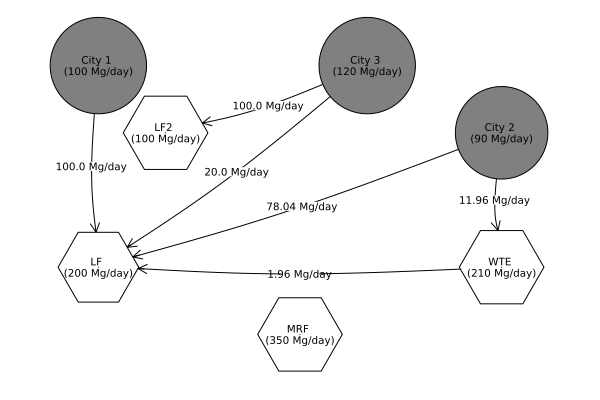

In [17]:
# construct diagram

names = [
    "City 1 \n(" * string(city1_dict["production"], " Mg/day)"),
    "City 2 \n(" * string(city2_dict["production"], " Mg/day)"),
    "City 3 \n(" * string(city3_dict["production"], " Mg/day)"),
    "WTE \n(" * string(WTE_dict["capacity"], " Mg/day)"),
    "MRF \n(" * string(MRF_dict["capacity"], " Mg/day)"),
    "LF \n(" * string(LF_dict["capacity"], " Mg/day)"),
    "LF2 \n(" * string(LF2_dict["capacity"], " Mg/day)")
]

# formatting
shapes = [:circle, :circle, :circle, :hexagon, :hexagon, :hexagon, :hexagon]
colors = [:gray, :gray, :gray, :white, :white, :white, :white]
sizes = 0.16
xpos = [-0.5, 2.5, 1.5, 2.5, 1, -0.5, 0]
ypos = [1, 0.5, 1, -0.5, -1, -0.5, 0.5]
cities = length(S) # offset for disposals being after cities in matrix

edge_labels = Dict(
    (city1, LF + cities) => string(value.(W1[city1, LF]), " Mg/day"),
    (city2, WTE + cities) => string(value.(W1[city2, WTE]), " Mg/day"),
    (city2, LF + cities) => string(value.(W1[city2, LF]), " Mg/day"),
    (city3, LF + cities) => string(value.(W1[city3, LF]), " Mg/day"),
    (city3, LF2 + cities) => string(value.(W1[city3, LF2]), " Mg/day"),
    (WTE + cities, LF + cities) => string(value.(R1[WTE, LF]), " Mg/day")
)

# build matrix based on connections
A = zeros(length(names), length(names))
[A[i[1], i[2]] = 1 for i in collect(keys(edge_labels))]

graphplot(A,
    names=names,
    edgelabel=edge_labels,
    markersizes=sizes,
    markershapes=shapes,
    markercolor=colors,
    x=xpos, y=ypos
)

#### Problem 2.4 (5 points)

Would you recommend that the cities build the new landfill? Why or why
not? Your answer should be based on your analysis but can draw on other
considerations as appropriate or desired.

In [18]:
# Using A and B, find the difference in optimal values when carbon tax is
#   in place with a new landfill versus no new landfill

println("With the carbon tax, the new landfill will change the cost by \$",
    round(obj_value_LF2 - obj_value_noLF2, digits=2), " per day")

With the carbon tax, the new landfill will change the cost by $-1081.06 per day


If the transportation cost increased to 2 USD/Mg-km and WTE's fixed cost incrased to 75 USD/day, then the cities should build the new landfill because it saves $1081.06 per day compared to if there was no landfill. Overall, this makes sense because the carbon tax will make disposal through WTE more expensive while also penalizing tranveling longer distances due to increased transportation cost. Therefore, building a new landfill is closer to some of the cities, specifically city 3, will ultimately reduce the cost of waste disposal. 

However, this is an ironic solution because the carbon tax is meant to punish harmful treatment of the environment (i.e. landfills) and reward recycling. In reality, the carbon tax incentivizess using and building landfills and discourages using recycling facilities. In order to make the carbon tax work as intended, perhap subsidies on the cost of recycling and a more targeted "landfill tax" could bring out the solution that was originally intended.

## References

List any external references consulted, including classmates.

BEE 4750 10/25 Lecture "Waste Management and Network Models" Slides & provided code (Big-M notation for JuMP)

BEE 4750 Homework 1: Introduction to Using Julia code for building diagrams